<a href="https://colab.research.google.com/github/jahanshukhy/Intro-to-Machine-Learning/blob/main/HW4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

In [138]:
# Load cancer dataset
from sklearn import datasets
dataset = datasets.load_breast_cancer()
X = dataset.data
Y = dataset.target
target_names = dataset.target_names

#check any NaN data
print( np.isnan(X).any())
print("Class counts:", pd.Series(Y).value_counts().to_dict())

False
Class counts: {1: 357, 0: 212}


In [139]:
#80/20 split for train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=10)

In [140]:
#evaluate with malignant (0) as the positive class
def eval_three(y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    rec  = recall_score(y_true, y_pred,    pos_label=0, zero_division=0)
    return acc, prec, rec

In [141]:
#Base pipeline (scaler to SVC)
base_pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC())])

In [142]:
# Use different kernels and varying C
C = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
kernel_cfgs = {
    "linear":  {"fixed": {"svc__kernel": "linear"},  "vary": {"svc__C": C}},
    "rbf":     {"fixed": {"svc__kernel": "rbf", "svc__gamma": "scale"}, "vary": {"svc__C": C}},
    "poly":    {"fixed": {"svc__kernel": "poly", "svc__degree": 3, "svc__gamma": "scale"}, "vary": {"svc__C": C}},
    "sigmoid": {"fixed": {"svc__kernel": "sigmoid", "svc__gamma": "scale"}, "vary": {"svc__C": C}},
}

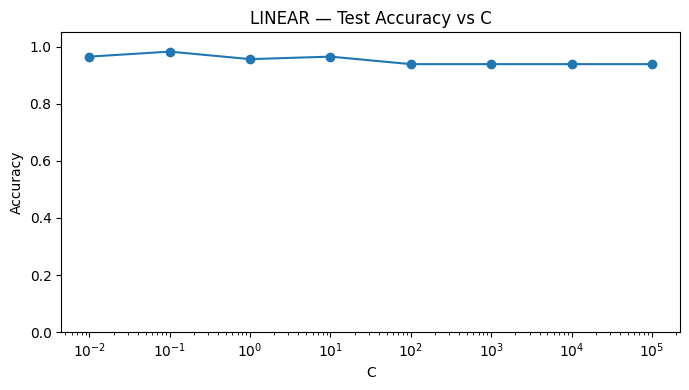

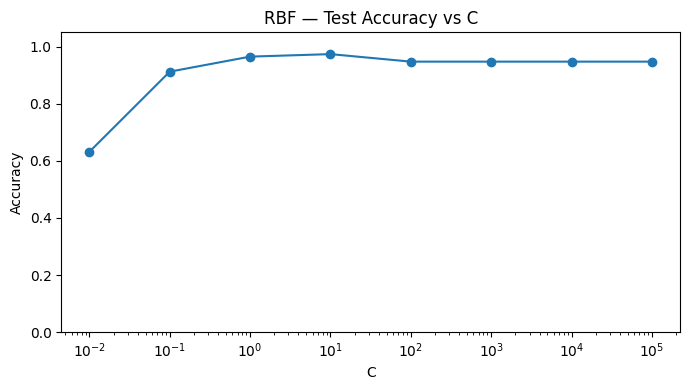

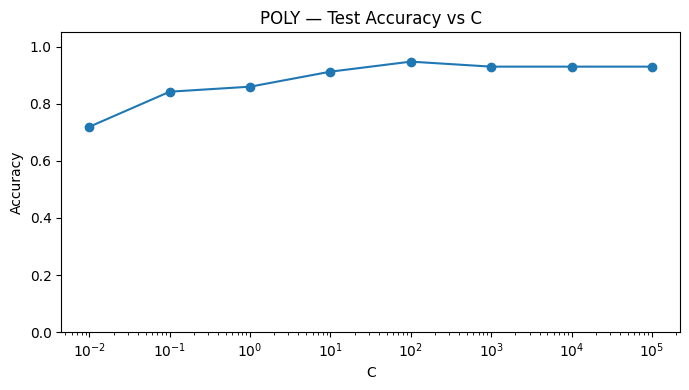

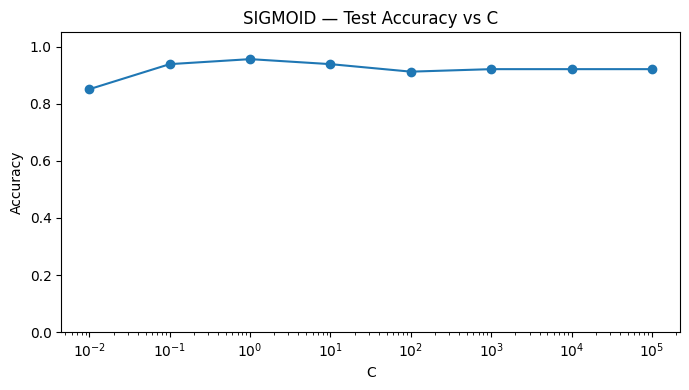

In [143]:
# varying gamma for rbf and
gamma_grid = ["scale", "auto", 1.0, 0.1, 0.01, 0.001]
all_results = []
best_per_kernel = {}

for kernel, cfg in kernel_cfgs.items():
    Cs = cfg["vary"]["svc__C"]

    # for RBF: sweep C and gamma
    if kernel == "rbf":
        accs_scale = []  # for the sensitivity plot (gamma='scale')
        best = {"acc": -1, "C": None, "gamma": None, "prec": None, "rec": None}

        for Cval in Cs:
            # store accuracy for gamma='scale' to make the same C-sensitivity plot
            model_scale = base_pipe.set_params(svc__kernel="rbf", svc__C=Cval, svc__gamma="scale")
            model_scale.fit(X_train, Y_train)
            yhat_scale = model_scale.predict(X_test)
            acc_scale, _, _ = eval_three(Y_test, yhat_scale)
            accs_scale.append(acc_scale)

            # full sweep over gamma for the actual best selection
            for g in gamma_grid:
                model = base_pipe.set_params(svc__kernel="rbf", svc__C=Cval, svc__gamma=g)
                model.fit(X_train, Y_train)
                yhat = model.predict(X_test)
                acc, prec, rec = eval_three(Y_test, yhat)

                all_results.append({
                    "Kernel": "rbf", "C": Cval, "gamma": g,
                    "Accuracy": acc, "Precision(malig)": prec, "Recall(malig)": rec
                })

                if acc > best["acc"]:
                    best.update({"acc": acc, "C": Cval, "gamma": g, "prec": prec, "rec": rec})

        # sensitivity plot for RBF (gamma='scale')
        plt.figure(figsize=(7,4))
        plt.semilogx(Cs, accs_scale, marker='o')
        plt.title("RBF — Test Accuracy vs C")
        plt.xlabel("C"); plt.ylabel("Accuracy"); plt.ylim(0, 1.05)
        plt.grid(False);
        plt.tight_layout();
        plt.show()

        best_per_kernel["rbf"] = {
            "C": best["C"], "gamma": best["gamma"],
            "Accuracy": best["acc"],
            "Precision(malig)": best["prec"],
            "Recall(malig)": best["rec"]
        }

    # for other kernels- linear, poly, sigmoid
    else:
        accs, precs, recs = [], [], []
        for Cval in Cs:
            model = base_pipe.set_params(**cfg["fixed"], svc__C=Cval)
            model.fit(X_train, Y_train)
            yhat = model.predict(X_test)
            acc, prec, rec = eval_three(Y_test, yhat)
            accs.append(acc); precs.append(prec); recs.append(rec)

            all_results.append({
                "Kernel": kernel, "C": Cval,
                "Accuracy": acc, "Precision(malig)": prec, "Recall(malig)": rec
            })

        # sensitivity plot (C on log x-axis)
        plt.figure(figsize=(7,4))
        plt.semilogx(Cs, accs, marker='o')
        plt.title(f"{kernel.upper()} — Test Accuracy vs C")
        plt.xlabel("C"); plt.ylabel("Accuracy"); plt.ylim(0, 1.05)
        plt.grid(False);
        plt.tight_layout();
        plt.show()

        best_idx = int(np.argmax(accs))
        best_per_kernel[kernel] = {
            "C": Cs[best_idx],
            "Accuracy": accs[best_idx],
            "Precision(malig)": precs[best_idx],
            "Recall(malig)": recs[best_idx],
        }



In [144]:
#summary table : best C per kernel and best gamma for rbf
summary_rows = []
order = ["rbf", "linear", "poly", "sigmoid"]
for k in order:
    bp = best_per_kernel[k]
    row = {
        "Model": f"SVM-{k}",
        "Best C": bp["C"],
        "Accuracy": bp["Accuracy"],
        "Precision (malignant)": bp["Precision(malig)"],
        "Recall (malignant)": bp["Recall(malig)"]
    }
    if k == "rbf":
        row["Best gamma"] = bp.get("gamma")
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("\n Best per kernel (80/20 split; metrics on test set)")
print(summary_df.round(4).to_string(index=False))



 Best per kernel (80/20 split; metrics on test set)
      Model  Best C  Accuracy  Precision (malignant)  Recall (malignant)  Best gamma
    SVM-rbf   100.0    0.9912                 1.0000              0.9762        0.01
 SVM-linear     0.1    0.9825                 0.9762              0.9762         NaN
   SVM-poly   100.0    0.9474                 0.9500              0.9048         NaN
SVM-sigmoid     1.0    0.9561                 0.9512              0.9286         NaN


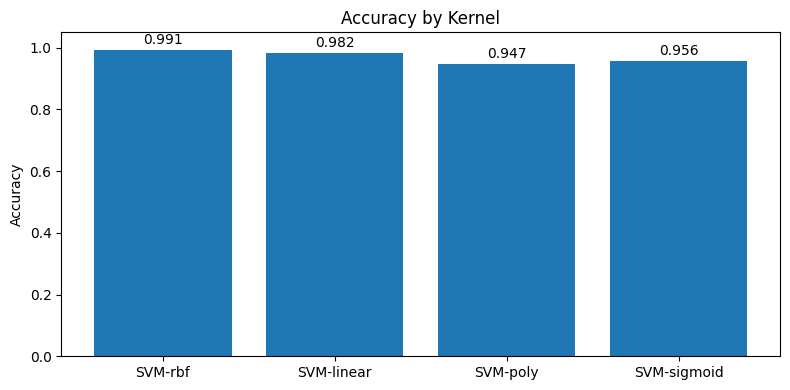

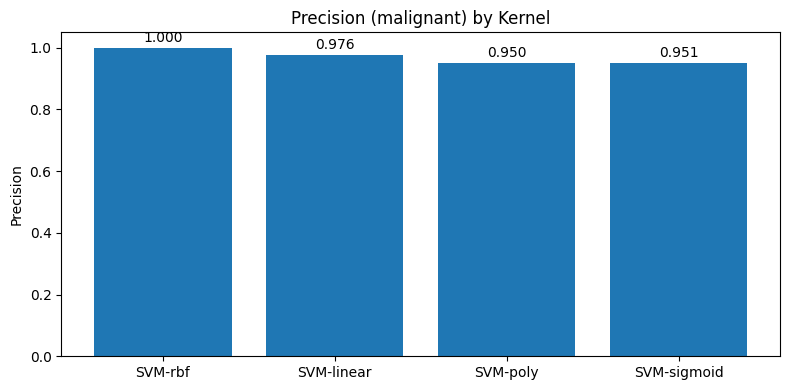

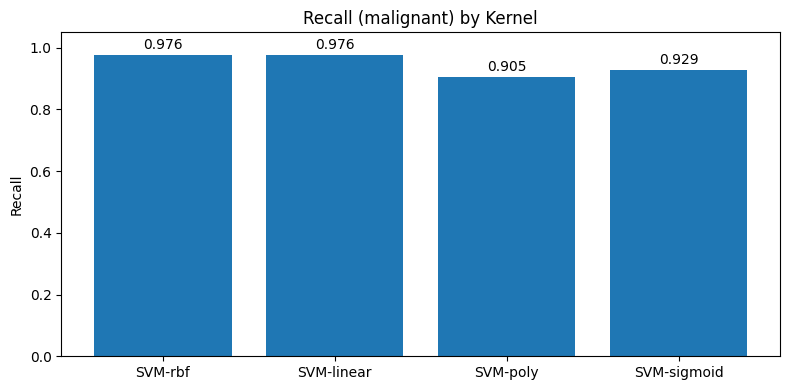

In [145]:
#bar charts to compare results
def bar_plot(labels, values, title, ylabel):
    fig, ax = plt.subplots(figsize=(8,4))
    bars = ax.bar(labels, values)  # define 'bars'
    ax.set_ylim(0, 1.05)
    ax.set_title(title)
    ax.set_ylabel(ylabel)

    for b, v in zip(bars, values):
        ax.text(
            b.get_x() + b.get_width()/2,
            b.get_height() + 0.01,
            f"{v:.3f}",
            ha="center", va="bottom"
        )

    fig.tight_layout()
    plt.show()

labels = [f"SVM-{k}" for k in order]
acc_vals  = [best_per_kernel[k]["Accuracy"]         for k in order]
prec_vals = [best_per_kernel[k]["Precision(malig)"] for k in order]
rec_vals  = [best_per_kernel[k]["Recall(malig)"]    for k in order]

bar_plot(labels, acc_vals,  "Accuracy by Kernel", "Accuracy")
bar_plot(labels, prec_vals, "Precision (malignant) by Kernel", "Precision")
bar_plot(labels, rec_vals,  "Recall (malignant) by Kernel", "Recall")

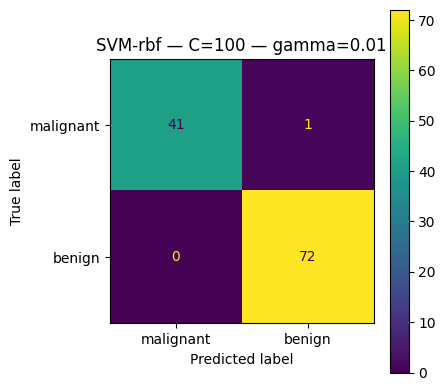

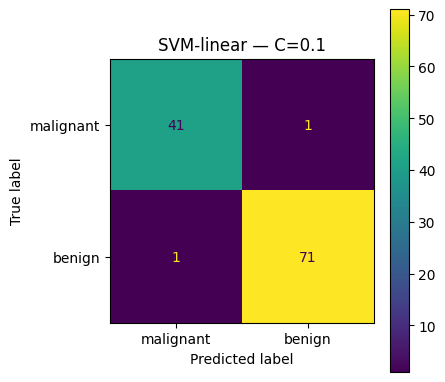

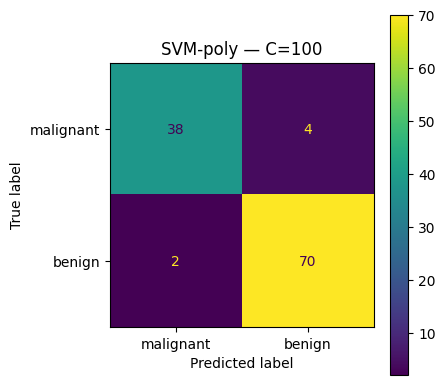

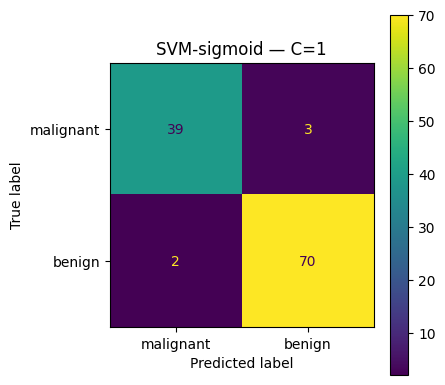

In [146]:
# Plot confusion matrices for all kernels at their best hyperparameters
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for kernel in ["rbf", "linear", "poly", "sigmoid"]:
    # start from the kernel's fixed config
    params = kernel_cfgs[kernel]["fixed"].copy()
    params["svc__C"] = best_per_kernel[kernel]["C"]

    # include any best params you recorded
    title_bits = [f"SVM-{kernel}", f"C={best_per_kernel[kernel]['C']}"]

    if kernel == "rbf":
        g = best_per_kernel[kernel].get("gamma")
        if g is not None:
            params["svc__gamma"] = g
            title_bits.append(f"gamma={g}")

    elif kernel == "poly":
        for p in ("degree", "gamma", "coef0"):
            if p in best_per_kernel[kernel]:
                params[f"svc__{p}"] = best_per_kernel[kernel][p]
                title_bits.append(f"{p}={best_per_kernel[kernel][p]}")

    elif kernel == "sigmoid":
        for p in ("gamma", "coef0"):
            if p in best_per_kernel[kernel]:
                params[f"svc__{p}"] = best_per_kernel[kernel][p]
                title_bits.append(f"{p}={best_per_kernel[kernel][p]}")

    # fit & plot
    model = base_pipe.set_params(**params).fit(X_train, Y_train)
    yhat = model.predict(X_test)

    cm = confusion_matrix(Y_test, yhat, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["malignant", "benign"])

    fig, ax = plt.subplots(figsize=(4.6, 4.2))
    disp.plot(ax=ax, values_format='d', colorbar=True)
    ax.set_title(" — ".join(title_bits))
    plt.tight_layout()
    plt.show()